

```
Usando a biblioteca  skorch que é um wrapper para pytorch e sklearn
que realiza validação cruzada com sklearn
```



In [45]:
!pip install skorch

In [46]:
from torch import nn
import pandas as pd
import numpy as np
from skorch import NeuralNetBinaryClassifier
from sklearn.model_selection import cross_val_score # validação cruzada
import torch
import seaborn as sns

In [47]:
from sklearn.datasets import load_breast_cancer

In [48]:
np.random.seed(123)
torch.manual_seed(123)

In [49]:
ds = load_breast_cancer()

In [50]:
print(ds['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [51]:
dsPreditores  = ds['data']
dsAlvo        = ds['target']

In [52]:
dsPreditores.shape

(569, 30)

In [53]:
dsAlvo.shape

(569,)

In [54]:
ds['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [55]:
df_preditores = pd.DataFrame(dsPreditores)

In [56]:
df_alvo = pd.DataFrame(dsAlvo)

<Axes: xlabel='0', ylabel='count'>

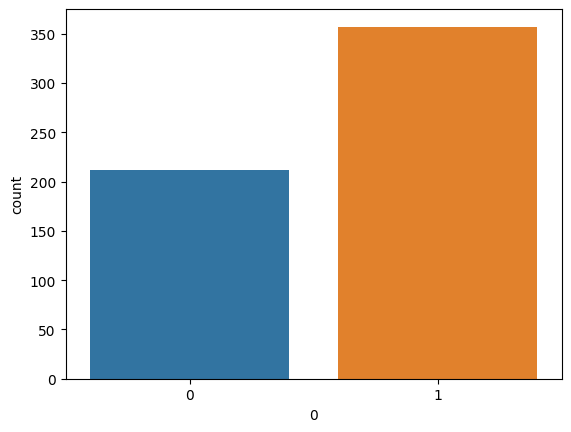

In [57]:
sns.countplot(x=df_alvo[0])

In [58]:
dsPreditores.dtype

dtype('float64')

In [59]:

dsPreditores = np.array(dsPreditores,dtype='float32')
dsAlvo = np.array(dsAlvo,dtype='float32')

In [60]:
dsAlvo.dtype,dsPreditores.dtype

(dtype('float32'), dtype('float32'))

Como o classsificador tem um objetivo de classificar binariamente,0 sem cancer e 1com cancer, podemos utilizar apenas um neuronio na saida e como temos 30 variaveis explanatorias (independentes ou preditoras), precisamos de 16 neuronios, pois usamos o calculo entradas+saida/2 -> (30+1)/2 = 15.5=16,    

In [61]:
class classidicadorTorch(nn.Module):
  def __init__(self):
    """
      a estrutura dessa rede neural é 30 -> 16 ->16->1
    """
    super().__init__()

    # primeira camada densa com 30 entradas ligado a 16 neuronios
    self.camada0 = nn.Linear(30,16)
    torch.nn.init.uniform_(self.camada0.weight) # inicia os pesos com uma distribuição uniforme
    self.camadaAtivacao0 = nn.ReLU()

    #segunda camada densa, cada camada oculta com 16 neuronios.
    self.camada1 = nn.Linear(16,16)
    torch.nn.init.uniform_(self.camada1.weight)
    self.camadaAtivacao1 = nn.ReLU()

    #camda de saida densa, camada oculta para camada de saida 16->1
    self.camadaSaida = nn.Linear(16,1)
    torch.nn.init.uniform_(self.camadaSaida.weight)
    # self.camadaAtivacaoSaida = nn.Sigmoid() #nesta versao nao precisa de sigmoid na saida, ele ja faz

  def forward(self,valoresEntrada):
    """
      Propagação dos valores dentro da rede neural
    """
    elemento = self.camada0(valoresEntrada)
    elemento = self.camadaAtivacao0(elemento)

    elemento = self.camada1(elemento)
    elemento = self.camadaAtivacao1(elemento)

    elemento = self.camadaSaida(elemento)
    # elemento = self.camadaAtivacaoSaida(elemento) #nesta versao nao precisa de sigmoid na saida, ele ja faz
    return elemento








In [62]:
# o parametro train_split não permite que seja separado o dataset em treino e teste pois
# será feito posteriomente pelo sklearn com validação cruzada, ou seja por padrão
# é separa em treino e teste

classificador_sklearn = NeuralNetBinaryClassifier(module = classidicadorTorch,\
                                                  criterion = torch.nn.BCEWithLogitsLoss,\
                                                  optimizer = torch.optim.Adam,\
                                                  lr = 0.001 ,\
                                                  optimizer__weight_decay = 0.0001,\
                                                  max_epochs = 100,\
                                                  batch_size = 10,\
                                                  train_split = False,\
                                                  )

após construção do classsificador podemos realizar a validação cruzada, para avaliar o nosso modelo e será utilizado a acuracia como metrica de avaliação poderia ser utilizado o f1-score, recall, precisao, já o valor de k-fold (cv) é 10

In [63]:
resultados =cross_val_score(classificador_sklearn,dsPreditores, dsAlvo, cv=10, scoring='accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1    35678.5899  0.0963
      2    28317.4645  0.0898
      3    22180.3231  0.0830
      4    17233.9144  0.1739
      5    13264.1854  0.2524
      6    10080.1095  0.1534
      7     7480.4298  0.0981
      8     5340.0735  0.0965
      9     3559.7626  0.1129
     10     2004.6531  0.1080
     11      599.5127  0.0804
     12       35.1469  0.1147
     13       32.2575  0.1504
     14       26.4348  0.1463
     15       21.1275  0.1049
     16       18.5674  0.0913
     17       16.7161  0.0963
     18       15.3442  0.0932
     19       14.6295  0.0861
     20       14.4738  0.0888
     21       13.4063  0.0809
     22       12.8779  0.0965
     23       11.4488  0.0934
     24       12.1469  0.0887
     25       10.9732  0.0818
     26        9.7949  0.0865
     27        8.7182  0.0848
     28        8.5717  0.0828
     29        8.3729  0.2638
     30        8.2927  0.1404
     31        8.2456  0.1357
     32   

In [64]:
resultados

array([0.87719298, 0.85964912, 0.94736842, 0.94736842, 0.87719298,
       0.9122807 , 0.87719298, 0.9122807 , 0.75438596, 0.92857143])

In [65]:
resultados.mean()

0.8893483709273182

In [66]:
resultados.std()

0.05372433439448073

Para evitar o overfiting realizaremos o Dropout, que é uma tecnica que consiste em apagar alguns neuronios (dropar) para evitar o overfiting para isso será construido outro classificador

In [67]:
class classificadorTorchDropOut(nn.Module):
  def __init__(self):
    """
      a estrutura dessa rede neural é 30 -> 16 ->16->1
    """
    super().__init__()

    # primeira camada densa com 30 entradas ligado a 16 neuronios
    self.camada0 = nn.Linear(30,16)
    torch.nn.init.uniform_(self.camada0.weight) # inicia os pesos com uma distribuição uniforme
    self.camadaAtivacao0 = nn.ReLU()
    self.camada0DropOut = nn.Dropout()

    #segunda camada densa, cada camada oculta com 16 neuronios.
    self.camada1 = nn.Linear(16,16)
    torch.nn.init.uniform_(self.camada1.weight)
    self.camadaAtivacao1 = nn.ReLU()
    self.camada1DropOut = nn.Dropout()

    #camda de saida densa, camada oculta para camada de saida 16->1
    self.camadaSaida = nn.Linear(16,1)
    torch.nn.init.uniform_(self.camadaSaida.weight)
    # self.camadaAtivacaoSaida = nn.Sigmoid() #nesta versao nao precisa de sigmoid na saida, ele ja faz

  def forward(self,valoresEntrada):
    """
      Propagação dos valores dentro da rede neural
    """
    elemento = self.camada0(valoresEntrada)
    elemento = self.camadaAtivacao0(elemento)
    elemento = self.camada0DropOut(elemento)

    elemento = self.camada1(elemento)
    elemento = self.camadaAtivacao1(elemento)
    elemento = self.camada1DropOut(elemento)

    elemento = self.camadaSaida(elemento)
    # elemento = self.camadaAtivacaoSaida(elemento) #nesta versao nao precisa de sigmoid na saida, ele ja faz
    return elemento

In [68]:

classificador_sklearn_dropOut = NeuralNetBinaryClassifier(module = classificadorTorchDropOut,\
                                                  criterion = torch.nn.BCEWithLogitsLoss,\
                                                  optimizer = torch.optim.Adam,\
                                                  lr = 0.001 ,\
                                                  optimizer__weight_decay = 0.0001,\
                                                  max_epochs = 100,\
                                                  batch_size = 10,\
                                                  train_split = False,\
                                                  )

In [69]:
resultados_2 =cross_val_score(classificador_sklearn_dropOut, dsPreditores, dsAlvo, cv=10, scoring='accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1    28340.6006  0.1560
      2    22223.2715  0.1446
      3    18100.3568  0.1390
      4    13940.9384  0.1564
      5    11856.9383  0.3037
      6     9238.4950  0.2089
      7     7248.0067  0.1616
      8     5251.9737  0.1003
      9     3776.0628  0.0950
     10     2831.0475  0.0998
     11     2093.4523  0.0959
     12     1696.4836  0.0988
     13     1515.7268  0.0939
     14     1528.2872  0.0908
     15      999.3610  0.1794
     16     1047.7006  0.1484
     17     1029.2627  0.1334
     18      786.9834  0.1092
     19      811.5067  0.0881
     20      691.0421  0.0970
     21      720.5678  0.0919
     22      637.9953  0.0998
     23      533.0970  0.0956
     24      509.5313  0.0975
     25      449.4963  0.0934
     26      409.8008  0.0925
     27      370.2640  0.0877
     28      336.9753  0.1035
     29      266.5409  0.0890
     30      246.1351  0.0856
     31      229.0967  0.2259
     32   

In [73]:
resultados_2

array([0.87719298, 0.61403509, 0.87719298, 0.8245614 , 0.78947368,
       0.61403509, 0.63157895, 0.78947368, 0.8245614 , 0.66071429])

In [74]:
resultados_2.mean()

0.7502819548872182

In [75]:
resultados_2.std()

0.10274184302813122